In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pandas as pd


In [2]:
import instrument as ins, isochrones as iso
import galaxy as gal, driver 
import fit_model, utils, gpu_utils

pycuda not installed.
GPU acceleration not available, sorry


In [6]:
import seaborn.apionly as sns

In [13]:
sns.set_context('notebook')

In [9]:
%matplotlib inline

In [5]:
df = pd.read_csv('results/delta_chi2.csv')
df.head()

,"N_scale: 1024, log_Npix: 0","N_scale: 1024, log_Npix: 2","N_scale: 1024, log_Npix: 4","N_scale: 128, log_Npix: 0","N_scale: 128, log_Npix: 2","N_scale: 128, log_Npix: 4","N_scale: 2048, log_Npix: 0","N_scale: 2048, log_Npix: 2","N_scale: 2048, log_Npix: 4","N_scale: 256, log_Npix: 0","N_scale: 256, log_Npix: 2","N_scale: 256, log_Npix: 4","N_scale: 512, log_Npix: 0","N_scale: 512, log_Npix: 2","N_scale: 512, log_Npix: 4"
0,-8985.184958,-2880.780135,-241.850468,-1620.723664,-804.871002,-180.063870,-9450.391316,-3328.948563,-158.995381,-2492.928025,-1717.025727,-151.403433,-7186.616502,-2649.485524,-143.183478
1,-8029.557274,-2677.158675,-210.057118,-2727.128215,-757.030891,-155.465394,-9739.268462,-3132.138660,-180.217390,-6243.315302,-1449.407024,-136.621694,-7484.228386,-2379.913712,-197.623673
2,-8471.199564,-2757.591687,-230.555627,-1566.475603,-901.758272,-98.728099,-10185.024624,-3467.327166,-210.050465,-3770.150691,-1971.824424,-187.296041,-5927.839140,-2321.330123,-155.090339
3,-8519.689864,-2819.055946,-185.386759,-1424.115528,-831.586382,-140.511216,-10072.179631,-3308.971917,-261.260131,-4370.481831,-1893.927870,-174.945131,-9148.703823,-2047.216855,-253.648167
4,-11603.813188,-2637.423280,-181.956244,-3309.737040,-952.186658,-231.179759,-9841.234365,-3381.451220,-172.648628,-3075.449961,-1512.428207,-115.969502,-7365.114299,-2507.245775,-197.558604


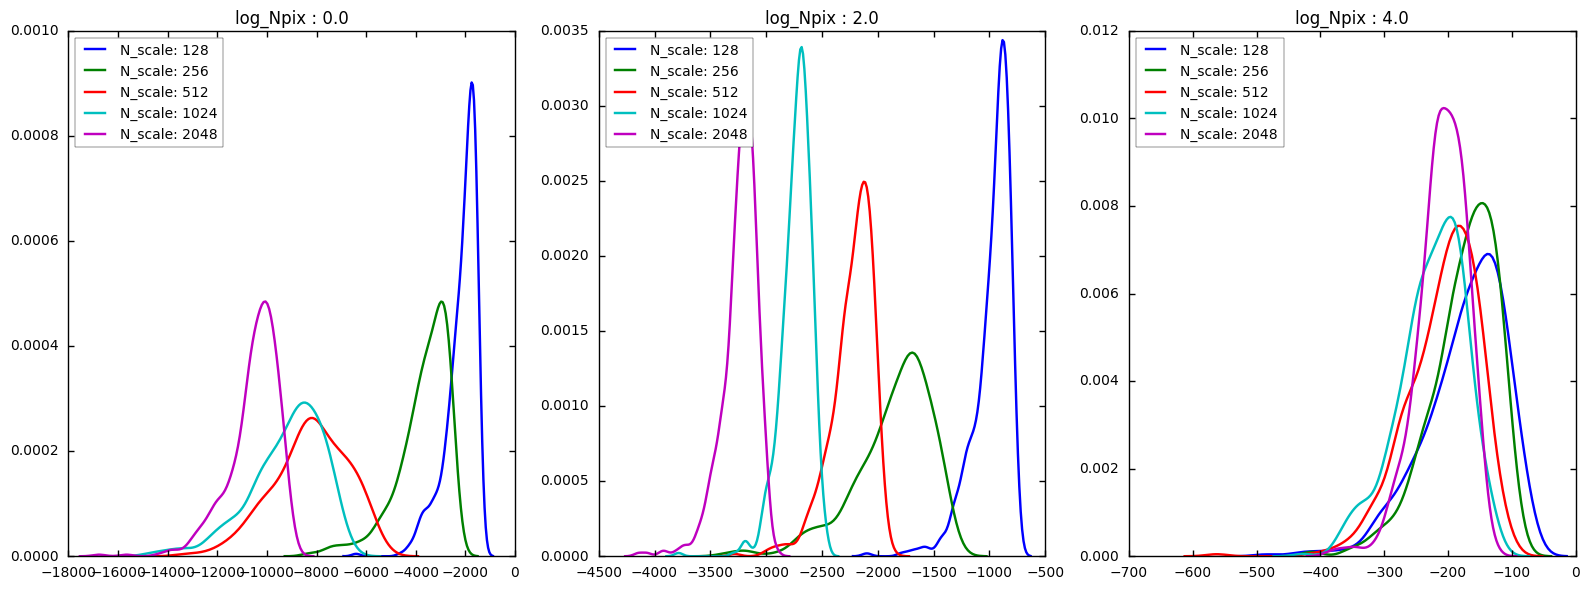

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
N_scales = [128, 256, 512, 1024, 2048]
log_Npixes = [0, 2, 4]
for i in range(len(log_Npixes)):
    axis = axes[i]
    for j in range(len(N_scales)):
        log_Npix = log_Npixes[i]
        N_scale = N_scales[j]
        label = 'N_scale: %d, log_Npix: %d'%(N_scale, log_Npix)
        vals = df[label].values
        sns.kdeplot(vals, label='N_scale: %d'%(N_scale), ax=axis)
    axis.set_title('log_Npix : %.1f'%(log_Npix))
    axis.legend(loc=2)
plt.tight_layout()

In [3]:
filters = [ins.Filter.HST_F475W(1.), ins.Filter.HST_F814W(1.)]
n_filters = len(filters)
iso_model = iso.Isochrone_Model(filters)
driver_gpu = driver.Driver(iso_model, gpu=True)

driver.py:24: RuntimeWarning: GPU acceleration not available. Continuing without.
  warnings.warn('GPU acceleration not available. Continuing without.', RuntimeWarning)


In [ ]:
n_scale = 1024

In [5]:
model_ssp = gal.Galaxy_SSP(np.array([0., -2., 2., 10.]))
model_full = gal.Galaxy_Model(np.array([0., -2., 0., 0., 0., 0., 0., 0., 0.]))

In [8]:
%%time
_ = driver_gpu.simulate(model_full, 1024)

CPU times: user 1.08 s, sys: 221 ms, total: 1.31 s
Wall time: 1.43 s


In [10]:
xbins, ybins = np.arange(-1.5, 4.6, 0.05), np.arange(-12, 15.6, 0.05)
bins = np.array([xbins, ybins])

In [ ]:
loglikes = {}
N_samples = 100
for N_scale in [128, 256, 512, 1024, 2048]:
    for log_Npix in [0., 2., 4.]:
        print((N_scale, log_Npix))
        temp = []
        model = gal.Galaxy_SSP(np.array([0., -2., log_Npix, 10.]))
        _, mags, _, _ = driver_gpu.simulate(model, N_scale)
        pcmd = utils.make_pcmd(mags)
        driver_gpu.initialize_data(pcmd, bins)
        assert(np.isclose(driver_gpu.loglike(pcmd), 0.))
        for i in range(N_samples):
            _, mags, _, _ = driver_gpu.simulate(model, N_scale)
            pcmd = utils.make_pcmd(mags)
            temp.append(driver_gpu.loglike(pcmd))
        loglikes[(N_scale, log_Npix)] = temp

(128, 0.0)
(128, 2.0)
(128, 4.0)
(256, 0.0)
(256, 2.0)
(256, 4.0)
(512, 0.0)
(512, 2.0)
(512, 4.0)
(1024, 0.0)
(1024, 2.0)


In [13]:
loglikes

{(128, 0.0): [-2048.021398271268, -3171.1733690008805],
 (128, 1.0): [-1172.2244478202274, -1147.2343711103479],
 (128, 2.0): [-1050.4976797815953, -895.50505036689515],
 (128, 3.0): [-396.03947588973915, -411.26483769873829],
 (128, 4.0): [-298.62420272438317, -260.95401798031781],
 (128, 5.0): [-51.95282863550878, -66.713937883128779],
 (256, 0.0): [-3938.5373822634792, -3573.5421068666647],
 (256, 1.0): [-2268.5777780797785, -2936.979287893731],
 (256, 2.0): [-1369.1592576601356, -1577.3729029416049],
 (256, 3.0): [-557.62268983308024, -575.06370197281115],
 (256, 4.0): [-243.1855822854827, -254.25519302629272],
 (256, 5.0): [-30.965254868361409, -50.581456904419852],
 (512, 0.0): [-7639.3732316654086, -6552.1138924109055],
 (512, 1.0): [-4011.5324220857128, -6507.9216570425679],
 (512, 2.0): [-2075.0868934427026, -1916.6019631581769],
 (512, 3.0): [-652.35232971917276, -626.27028133999329],
 (512, 4.0): [-144.77781000793226, -168.61180458249237],
 (512, 5.0): [-49.464072069868763, 